## Imports

In [2]:
from helpers.training import *
from helpers.data import *
from helpers.utilities import *
from models.VAE import *
from tqdm import tqdm
from helpers.utilities import transform, inv_transform
from helpers.functions import get_assymetry, get_shower_width
import matplotlib.pyplot as plt
import matplotlib

/apps/miniconda3/envs/june2020-gpu/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [2]:
mlflow.tracking.set_tracking_uri('file:/share/lazy/will/ConstrastiveLoss/Molecules/mlruns')
mlflow.set_experiment('Calo-ML')

/apps/miniconda3/envs/june2020-gpu/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Main training/validation loop. Only a few metrics are printed here during training, see MLFlow for all metrics over time!

In [3]:
# args are "n", number of channels per layer, and "z_dim", number of dimensions in the latent space. z_dim gets sandwiched between linear layers so it can be basically
# whatever, kl term in loss only looks at this layer... i think?
device = 'cuda:0'
# path = '/share/lazy/will/ConstrastiveLoss/Molecules/mlruns/8/120d2944767a4894b3ce60bed41fd681/artifacts/run_stats.pyt'
path = 'vqvae_binarymask_convdecoder2.pyt'
loader = get_train_val_loaders(32, device)

with mlflow.start_run(run_name = 'VAE') as run:

    model = VQVAE().to(device)
    model.load_state_dict(torch.load(path), strict=True)    
    optimizer = optim.Adam(model.parameters(), lr=3e-6)
    
    for epoch in range(vae_params.no_epochs):
        # latent_loss_weight is usually ~0.006 for VQVAE, ~0.0003 for VAE
        [None for i in train_VAE(epoch, loader, model, optimizer, device, latent_loss_weight = 0.0005, train=True)]
         

# occasionally use for when a training run is going to be used to generate figures?
# torch.save(model.state_dict(), 'vqvae_binarymask_convdecoder.pyt')

/apps/miniconda3/envs/june2020-gpu/lib/python3.7/site-packages/tables/array.py:241: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  (oid, self.atom, self.shape, self._v_chunkshape) = self._open_array()
/apps/miniconda3/envs/june2020-gpu/lib/python3.7/site-packages/tables/atom.py:1224: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  return pickle.loads(array.tostring())


torch.Size([160000, 1, 32, 32])
torch.Size([10000, 1, 32, 32])


  0%|          | 0/5000 [00:00<?, ?it/s]/data/home/will/Calo-ML/models/VAE.py:207: DeprecationWarning: 'saved_variables' is deprecated; use 'saved_tensors'
  result, i = ctx.saved_variables
epoch: 1; mse: 0.30621; latent: 14331.407; BCE loss: 0.777; Momentum: 0.030 lr: 0.00000mse: 0.26050:   2%|▏         | 122/5000 [00:15<10:28,  7.76it/s]
/data/home/will/.local/lib/python3.7/site-packages/tensorflow_core/contrib/learn/python/learn/learn_io/generator_io.py:26: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Container


KeyboardInterrupt: 

## This bit of code runs through some data and generates Dr. Ratnikov's figures of merit for this task. 

In [18]:
# First step is to generate the real/fake events including attributes (currently just momentum)
truth_data = []
truth_ps = []
truth_points = []

fake_data = []
fake_ps = []
fake_points = []

for i in range(300):
    batch = loader.get_train_batch()
    data, ps, points = batch
    decoded_img, pred_props, decoded_mask, KLD = model(data)
    pred_positions, pred_momentum = pred_props[:, :2], pred_props[:, 2:]
    pred_data = decoded_img*(decoded_mask>torch.rand_like(decoded_mask))
    
    fake_data.append(pred_data.detach().cpu().numpy())
    fake_ps.append(pred_momentum.detach().cpu().numpy())
    
    truth_data.append(data.cpu().numpy())
    truth_ps.append(ps.cpu().numpy())
    truth_points.append(points.cpu().numpy())
    
    
truth_points = np.concatenate(truth_points, axis=0)
truth_ps = np.concatenate(truth_ps, axis=0)
truth_data = np.concatenate(truth_data, axis=0)[:, 0, 1:-1, 1:-1]
fake_data = np.concatenate(fake_data, axis=0)[:, 0, 1:-1, 1:-1]
fake_ps = np.concatenate(fake_ps, axis=0)

asymmetry_direct_real = get_assymetry(truth_data, truth_ps, truth_points)
asymmetry_perp_real = get_assymetry(truth_data, truth_ps, truth_points, orthog=True)
asymmetry_direct_fake = get_assymetry(fake_data, truth_ps, truth_points)
asymmetry_perp_fake = get_assymetry(fake_data, truth_ps, truth_points, orthog=True)

shower_width_real_direct = get_shower_width(truth_data, truth_ps, truth_points)
shower_width_real_perp = get_shower_width(truth_data, truth_ps, truth_points, orthog=True)
shower_width_fake_direct = get_shower_width(fake_data, truth_ps, truth_points)
shower_width_fake_perp = get_shower_width(fake_data, truth_ps, truth_points, orthog=True)

100%|██████████| 9600/9600 [00:27<00:00, 349.91it/s]


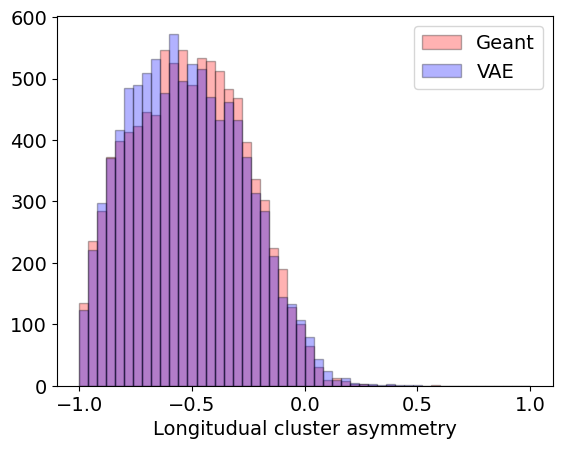

In [15]:
import matplotlib
matplotlib.rcParams.update({'font.size': 14})
plt.hist(asymmetry_direct_real, bins=50, range=[-1,1], color='red', alpha=0.3, edgecolor='black', label='Geant');
#plt.title('Energy assymetry in direction')
plt.hist(asymmetry_direct_fake, bins=50, range=[-1,1], color='blue', alpha=0.3, edgecolor='black', label='VAE');
plt.xlabel('Longitudual cluster asymmetry')
plt.legend(loc='best')
plt.show()

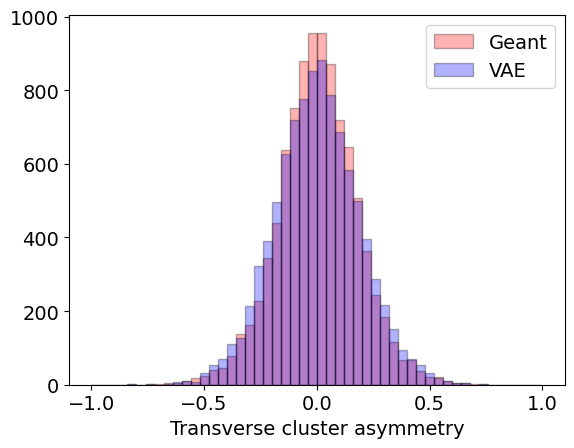

In [16]:
matplotlib.rcParams.update({'font.size': 14})
plt.hist(asymmetry_perp_real, bins=50, range=[-1,1], color='red', alpha=0.3, edgecolor='black', label='Geant');
plt.hist(asymmetry_perp_fake, bins=50, range=[-1,1], color='blue', alpha=0.3, edgecolor='black', label='VAE');
plt.xlabel('Transverse cluster asymmetry')
plt.legend(loc='best')
plt.show()

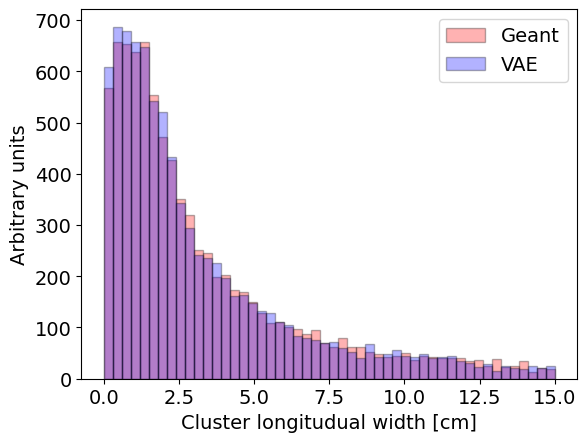

In [19]:
plt.hist(shower_width_real_direct, bins=50, range=[0,15], edgecolor='black', alpha=0.3, color='red', label='Geant');
plt.hist(shower_width_fake_direct, bins=50, range=[0,15], edgecolor='black', alpha=0.3, color='blue', label='VAE');
#plt.title('Shower longitudial width')
plt.legend(loc='best')
plt.xlabel('Cluster longitudual width [cm]')
plt.ylabel('Arbitrary units')
plt.show()

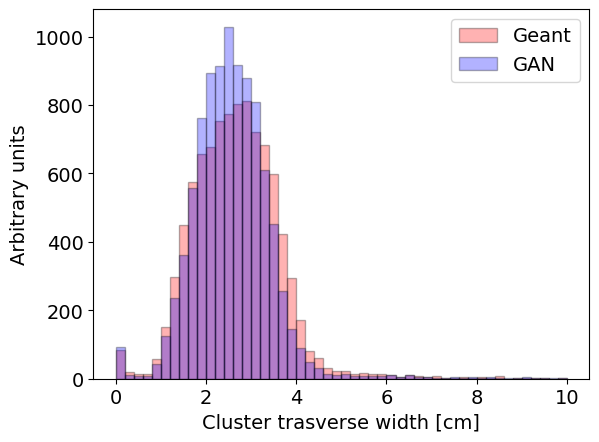

In [20]:
matplotlib.rcParams.update({'font.size': 14})
plt.hist(shower_width_real_perp, bins=50, range=[0,10], edgecolor='black', alpha=0.3, color='red', label='Geant');
plt.hist(shower_width_fake_perp, bins=50, range=[0,10], edgecolor='black', alpha=0.3, color='blue', label='GAN');
#plt.title('Shower transverse width')
plt.legend(loc='best')
plt.xlabel('Cluster trasverse width [cm]')
plt.ylabel('Arbitrary units')
plt.show()

In [25]:
def get_ms_ratio2(data, ps, i, alpha=0.1):
    img = data[i]
    ms = np.sum(img)
    ms_ = ms * alpha
    num = np.sum((img >= ms_))
    return num / 900.

def get_ms_ratio(data, ps, i, alpha=0.1):
    img = data[i]
    p = ps[i]
    ms = np.sqrt(np.sum(p**2))
    ms_ = ms * alpha
    num = np.sum((img >= ms_))
    return num / 900.0

In [33]:
#alpha = np.linspace(0, 0.02, 100)
alpha = np.linspace(-5, 0, 50)
sparsity_real = []
sparsity_fake = []
for i in tqdm(range(3000)):
    v_r = []
    v_f = []
    for alpha_ in alpha:
        v_r.append(get_ms_ratio2(truth_data, truth_ps, i, pow(10,alpha_)))
        v_f.append(get_ms_ratio2(fake_data, truth_ps, i, pow(10,alpha_)))
        
    sparsity_real.append(v_r)
    sparsity_fake.append(v_f)

/apps/miniconda3/envs/june2020-gpu/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
100%|██████████| 3000/3000 [00:05<00:00, 556.83it/s]


In [34]:
res_r = np.array(sparsity_real)
res_f = np.array(sparsity_fake)

means_r = np.mean(res_r, axis=0)
stddev_r = np.std(res_r, axis=0)

means_f = np.mean(res_f, axis=0)
stddev_f = np.std(res_f, axis=0)

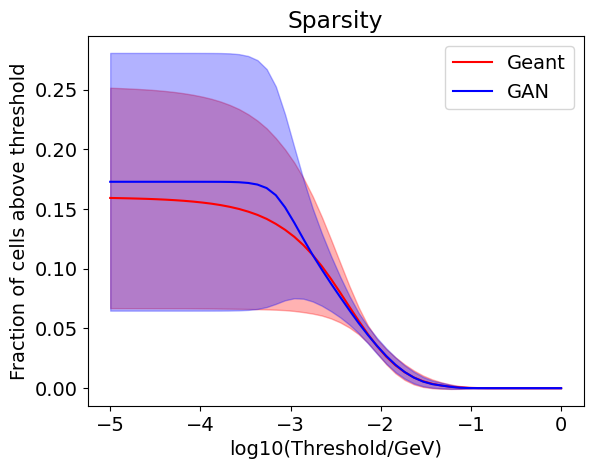

In [35]:
matplotlib.rcParams.update({'font.size': 14})
plt.plot(alpha, means_r, color='red')
plt.fill_between(alpha, means_r-stddev_r, means_r+stddev_r, color='red', alpha=0.3)
plt.plot(alpha, means_f, color='blue')
plt.fill_between(alpha, means_f-stddev_f, means_f+stddev_f, color='blue', alpha=0.3)
plt.legend(['Geant', 'GAN'])
plt.title('Sparsity')
plt.xlabel('log10(Threshold/GeV)')
plt.ylabel('Fraction of cells above threshold')
plt.show()

## This code just performs a quick+easy benchmark of performance

In [49]:
from time import time
time1 = time()
with torch.no_grad():
    for i in range(1000):    
        data, ps, points = batch
        decoded_img, pred_props, decoded_mask, KLD = model(data)
    
print(f'processed {32*1000} events in {time()-time1} seconds')

processed 32000 events in 5.315839529037476 seconds


### This bit of code generates the smooth predicted distribution, as well as the combined (mask+smooth dist) to show how masking impacts the final histogram. It also shows the ground truth so you can make comparisons 

In [ ]:
model = torch.load('vae_binarymask_convdecoder.pyt')

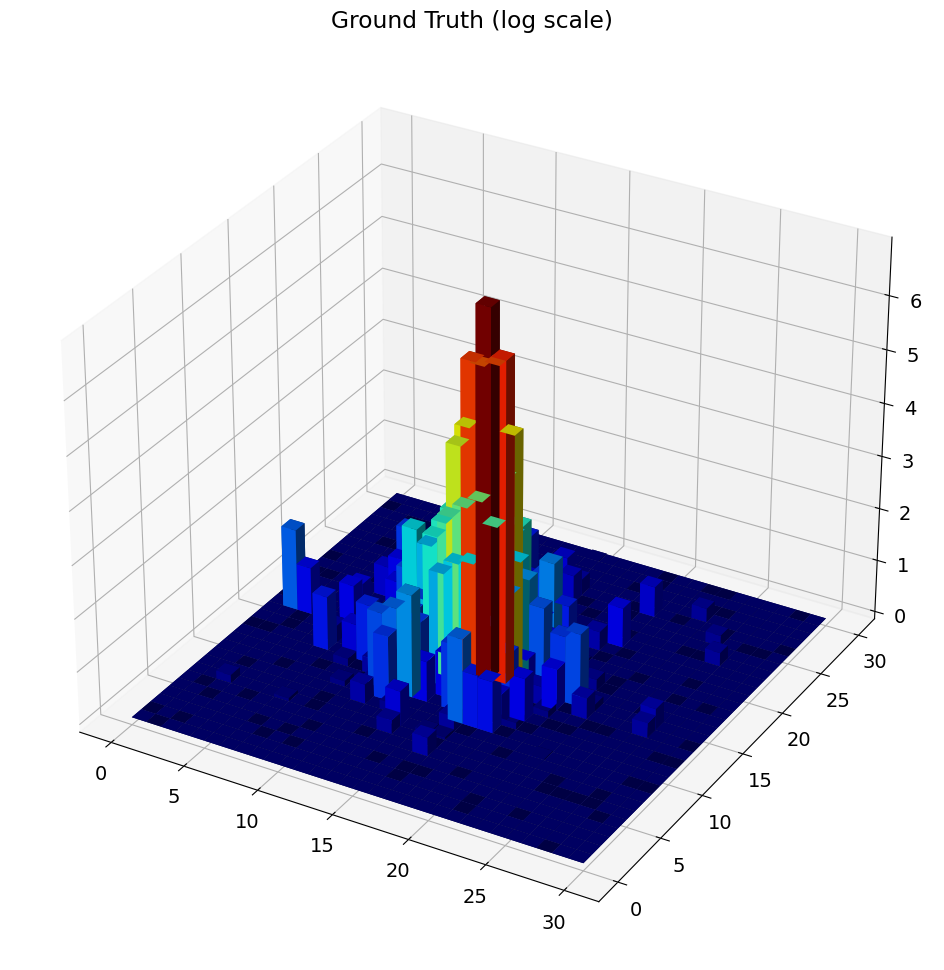

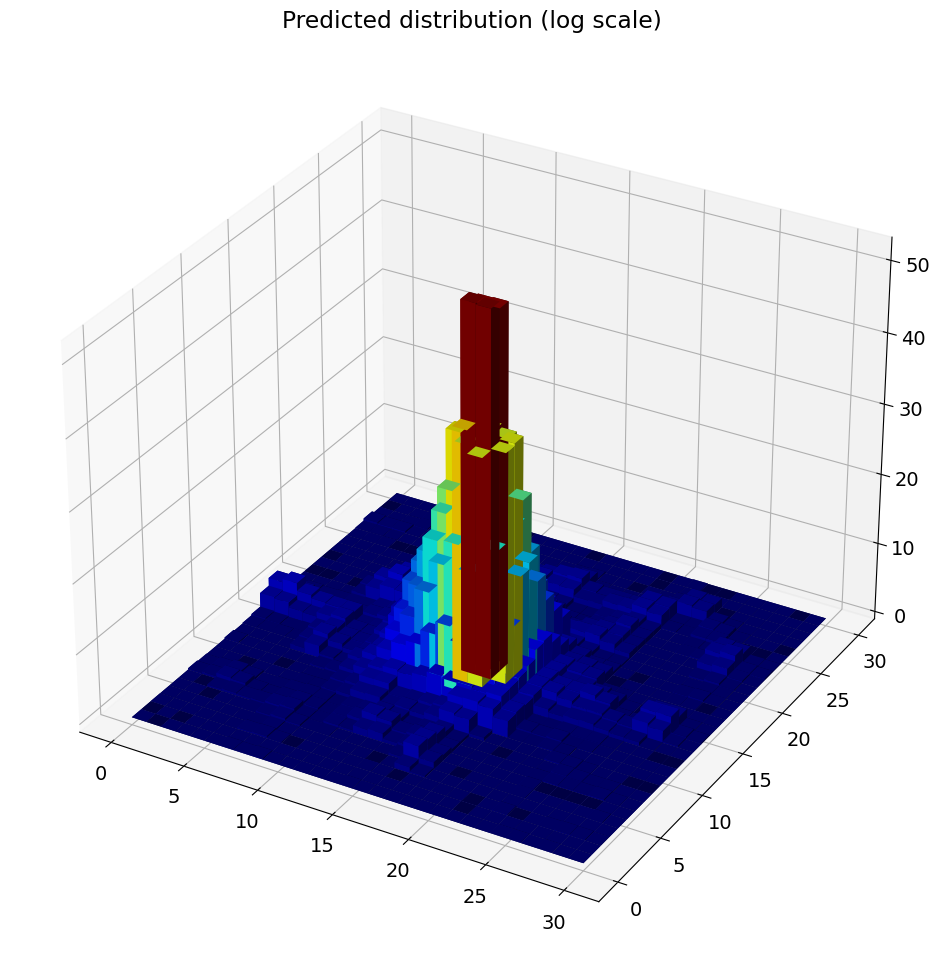

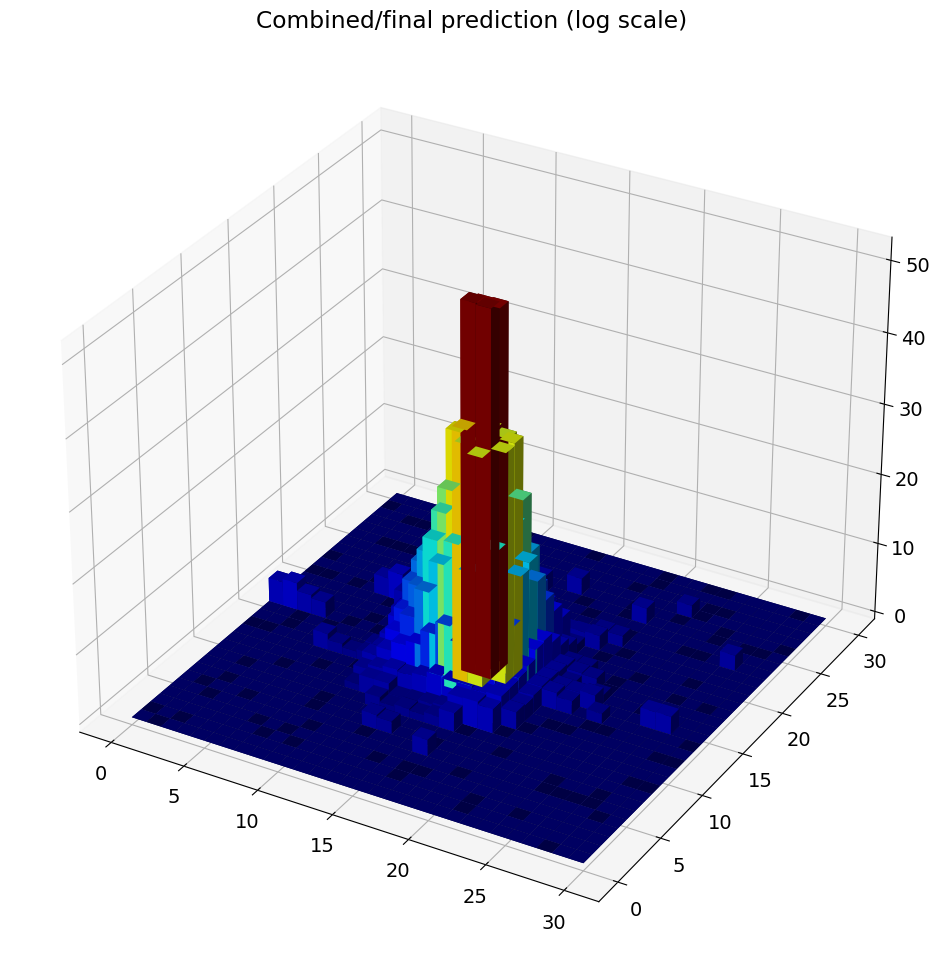

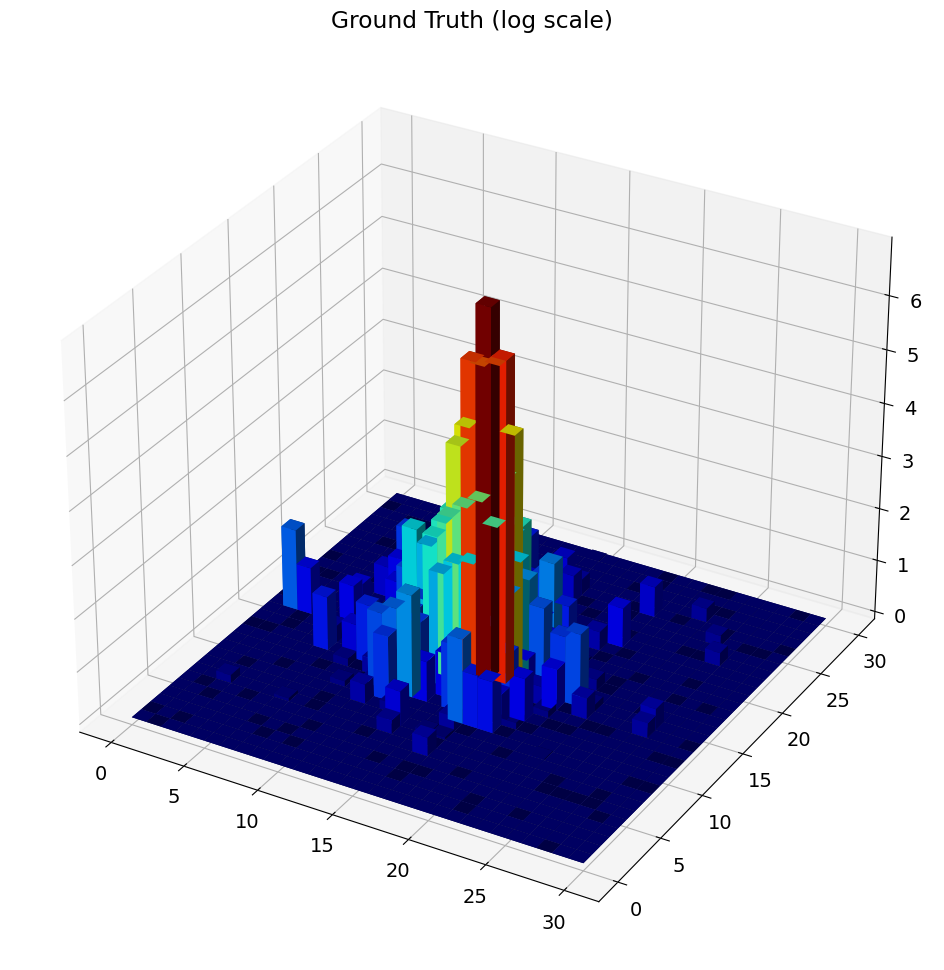

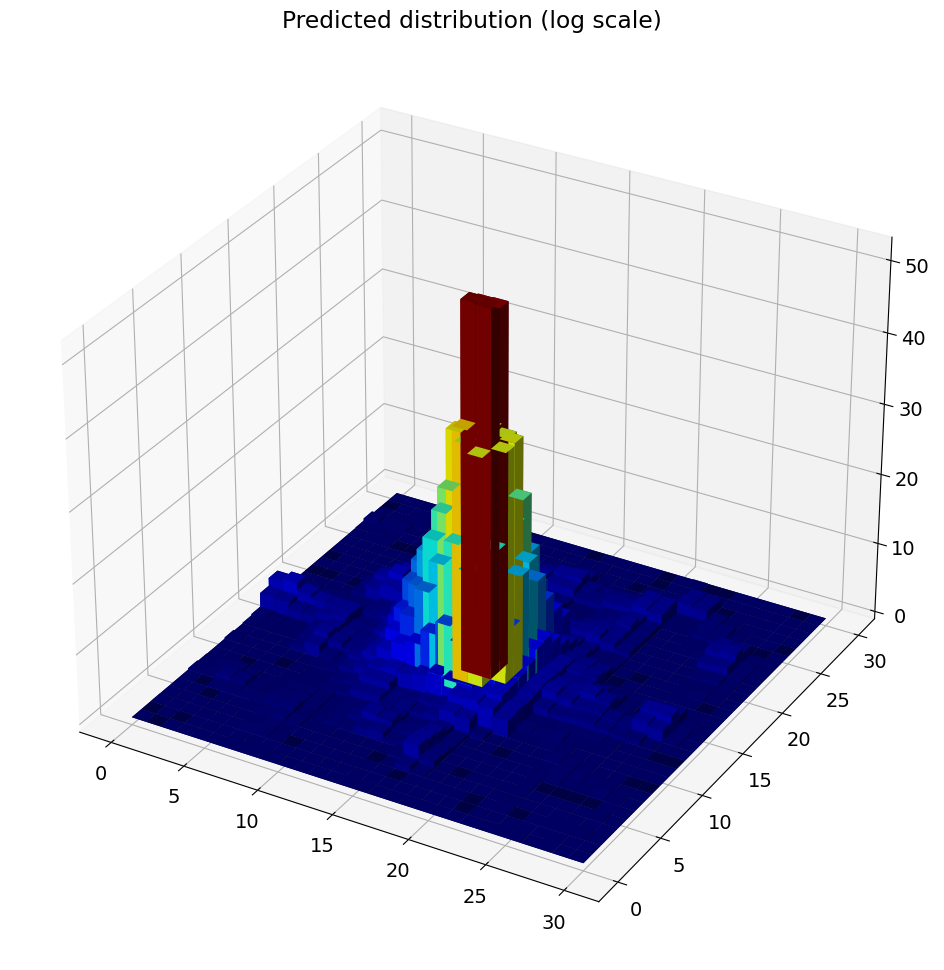

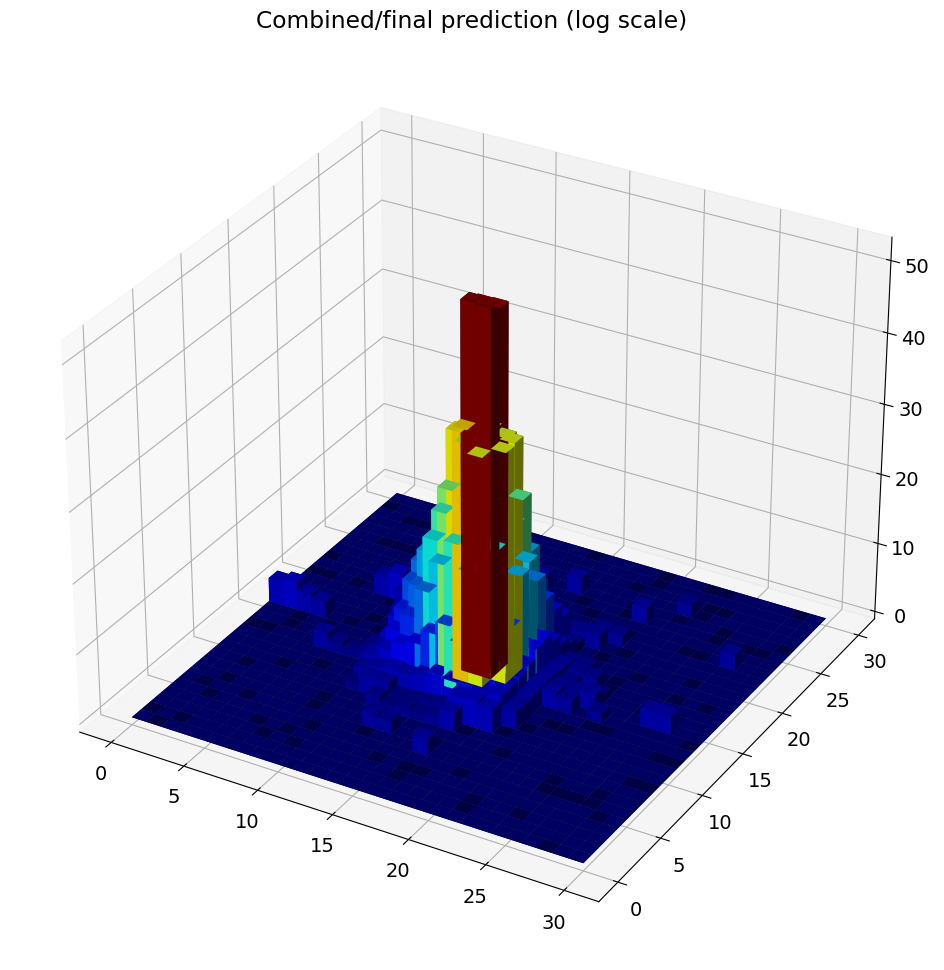

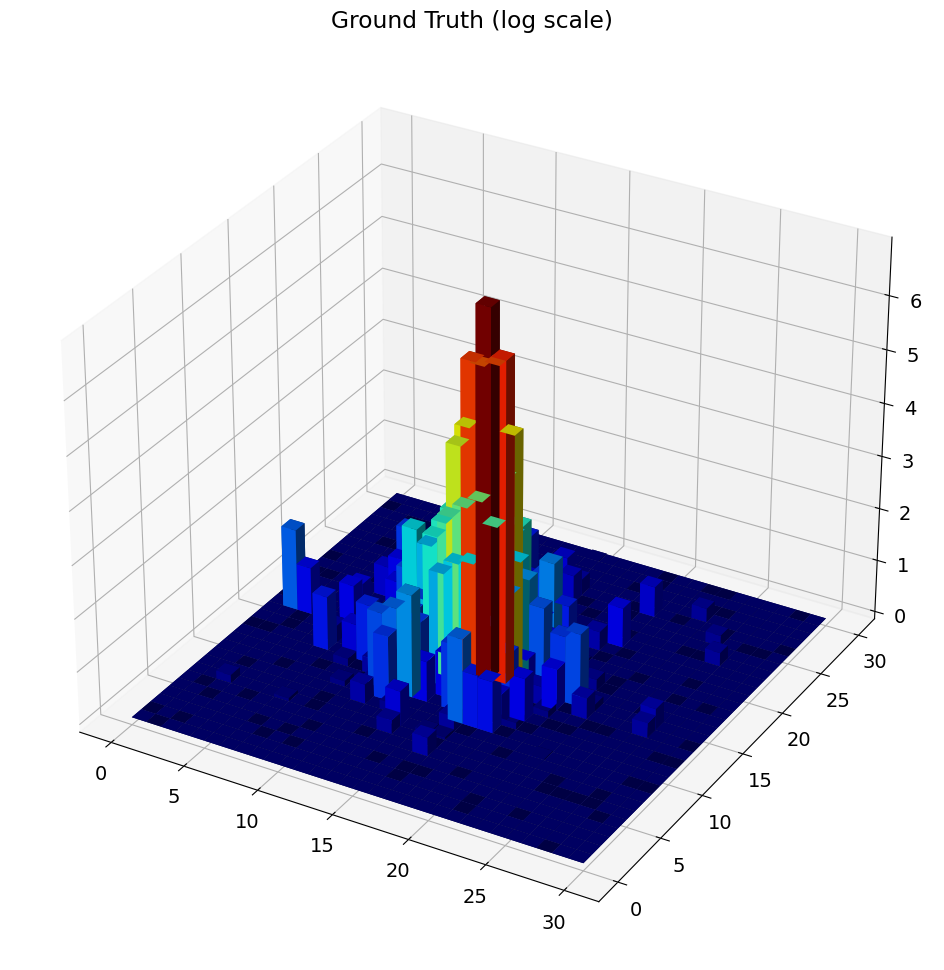

KeyboardInterrupt: 

In [12]:
latent_vecs = []
momentum = []
for _ in range(5):
    with torch.no_grad():
        
        images = loader.val_array[34:32*2].to(device)#, loader.val_attributes[34:32*2].to(device)
        decoded_img, pred_props, decoded_mask, KLD = model(images)
        bool_dec = (decoded_mask>torch.rand_like(decoded_mask)).float().squeeze()
        
        binary_array = (bool_dec.cpu().permute(1, 2, 0).numpy() > 0.5).astype(np.float32)
        truth_binary_array = (images.cpu()[0].permute(1, 2, 0).numpy() > 0).astype(np.float32)
        truth_img = np.dstack((truth_binary_array, truth_binary_array, truth_binary_array))
        
        plot_3d_bar(images.cpu()[0][0].numpy()[1:-1, 1:-1], 30, 'Ground Truth (log scale)', f"delete.jpg")
        plot_3d_bar(decoded_img.cpu()[0][0].numpy()[1:-1, 1:-1], 30, 'Predicted distribution (log scale)', f"delete.jpg")
        plot_3d_bar((bool_dec > 0.5)[0].float().cpu().numpy()[1:-1, 1:-1]*decoded_img.cpu()[0][0].numpy()[1:-1, 1:-1], 30, 'Combined/final prediction (log scale)', f"delete.jpg")
#         plot_3d_bar(np.abs(images.cpu()[0][0].numpy()[1:-1, 1:-1]-((decoded_mask > 0.5)[0].float().cpu().numpy()[1:-1, 1:-1]*decoded_img.cpu()[0][0].numpy()[1:-1, 1:-1])), 30, 'Error (log scale)', f"delete.jpg")

        plt.show()

## This bit of code generates visualzations similar to the above, but flattened, so you can make the same comparisons with a single image. mainly meant to evaluate the quality of the masking

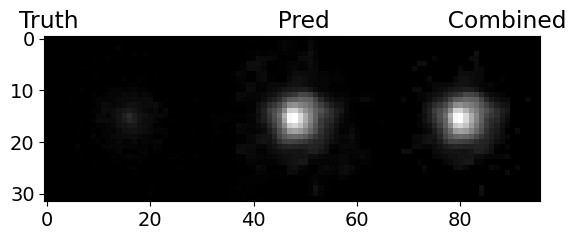

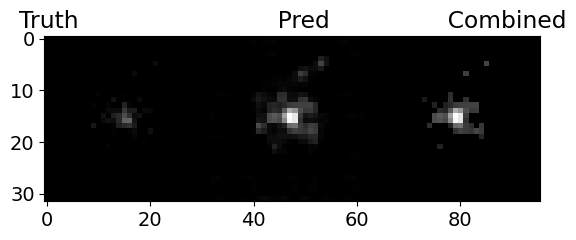

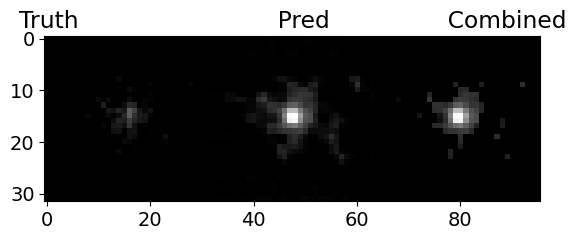

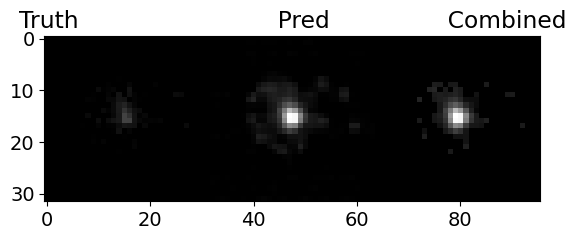

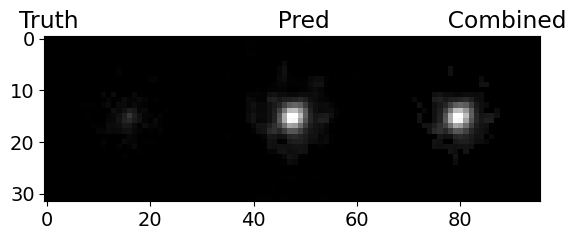

In [22]:
latent_vecs = []
momentum = []

for _ in range(5):
    with torch.no_grad():
        
        images, momentum, positions = loader.get_train_batch()
        dec, pred_props, bool_dec, latent_loss = model(images)
        
        bool_dec_plot = bool_dec.cpu()[0].permute(1, 2, 0)#.numpy()
        binary_array = (bool_dec_plot.numpy() > torch.rand_like(bool_dec_plot).numpy()).astype(np.float32)
        pred_img = np.dstack((binary_array, binary_array, binary_array))

        truth_binary_array = (images.cpu()[0].permute(1, 2, 0).numpy() > 0).astype(np.float32)
        truth_img = np.dstack((truth_binary_array, truth_binary_array, truth_binary_array))

#         plt.imshow(np.hstack((truth_img, pred_img)))
#         plt.title('Truth                                      Pred')
#         plt.show()

        plt.imshow(torch.cat((images.cpu()[0][0], dec.cpu()[0][0], dec.cpu()[0][0]*(bool_dec.cpu()[0][0]>0.5)), dim=1).numpy(), cmap='Greys_r', interpolation='nearest')
        plt.title('Truth                           Pred                Combined')
        plt.show()


## This performs a PCA to 2d to see what is learned in the latent dimensions. At least with regard to the momentum!

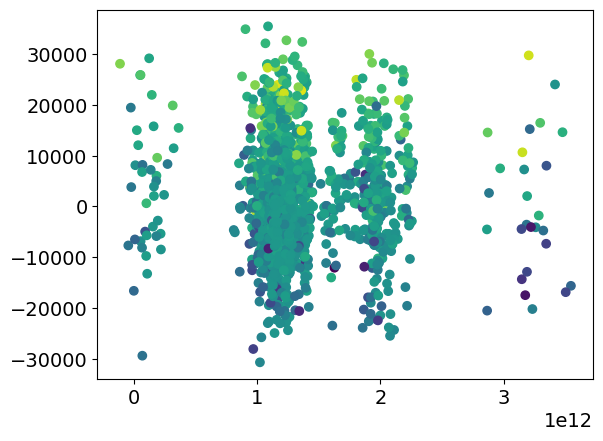

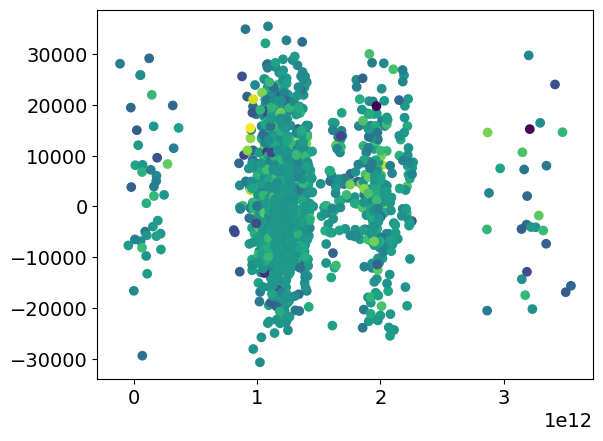

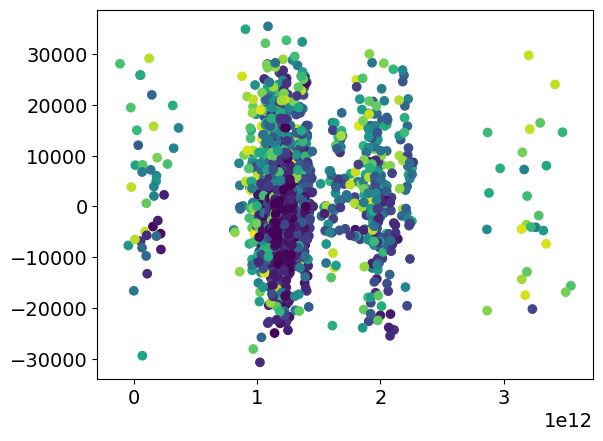

In [23]:
momentum = []
latent_vecs = []
for i in range(100):
    images, p, positions = loader.get_train_batch()
    quant_t, quant_b, _, _, _ = model.encode(images)
    latent_vecs.append(quant_t)
    momentum.append(p)

latent_tensor = torch.cat(latent_vecs).flatten(1)
momentum_tensor = torch.cat(momentum)

cov_matrix = torch.matmul(latent_tensor.T, latent_tensor)

v, w = torch.eig(cov_matrix.cpu(), eigenvectors=True)
array = torch.matmul(latent_tensor.cuda(), v[:, :2].cuda()).detach().cpu().numpy()   

import matplotlib.pyplot as plt
for i in range(3):
    plt.scatter(array[:, 0], array[:, 1], c=momentum_tensor[:, i].cpu().numpy())
    plt.show()


## Evaluate the quality of energy predictions. This is no longer relevant, since we are now predicting the percent of total (given) energy of the event. Alternative approaches may still find use in this... so it remains

In [ ]:
pred_array = []
truth_array = []

pred_asymmetry = []
truth_asymmetry = []

pred_asymmetry_orthog = []
truth_asymmetry_orthog = []

momentum = []
pred_momentum = []

with torch.no_grad():
    for i in tqdm(range(1000)):
        images, p, positions = loader.get_train_batch()
        truth_array.append(images.cpu())
        momentum.append(p.cpu())
        truth_asymmetry.append(asymmetry(images, p, positions).cpu())
        truth_asymmetry_orthog.append(asymmetry(images, p, positions, orthog=True).cpu())

        out, pred_props, bool_dec, latent_loss = model(images)
        out = out * (bool_dec > torch.rand_like(bool_dec))
#         out = out*(bool_dec>0.5)
        pred_array.append(out.cpu()) 
        pred_positions, pred_p = pred_props[:, :2], pred_props[:, 2:]
        pred_momentum.append(pred_p.cpu())

        pred_asymmetry.append(asymmetry(out, pred_p, pred_positions).cpu())
        pred_asymmetry_orthog.append(asymmetry(out, pred_p, pred_positions, orthog=True).cpu())

truth_array = torch.cat(truth_array)    
pred_array = torch.cat(pred_array)
pred_momentum = torch.cat(pred_momentum)
momentum = torch.cat(momentum)    

In [ ]:
truth_E = truth_array.sum(dim=(1,2,3))
pred_E = pred_array.sum(dim=(1,2,3))

In [ ]:
plt.clf()

In [ ]:
plt.hist(pred_E.unsqueeze(0), bins=50, color='blue', alpha=0.3, label='VAE', edgecolor='black', linewidth=1.2, range=(0, 1000))
plt.hist(truth_E.unsqueeze(0), bins=50, color='red', alpha=0.3, label='Geant', edgecolor='black', linewidth=1.2, range=(0, 1000))
plt.xlabel('Total energy (log-sum)')
plt.title('Log scaling')
plt.legend()
plt.show()

In [ ]:
truth_E_exp = (torch.exp(truth_array)-1).sum(dim=(1,2,3))
pred_E_exp = (torch.exp(pred_array)-1).sum(dim=(1,2,3))

In [ ]:
plt.scatter(pred_E_exp.unsqueeze(0), truth_E_exp.unsqueeze(0), alpha=0.1)
plt.xlabel('VAE Total energy (sum)')
plt.xlabel('Geant Total energy (sum)')
plt.plot([0,18000],[0,18000])
plt.show()

In [ ]:
# ise MSE for error at higher energies, regular loss function for smaller energies
# (pred-total / total )
plt.hist(pred_E_exp.unsqueeze(0), bins=75, color='blue', alpha=0.3, label='VAE', edgecolor='black', linewidth=1.2, range=(0, 25000))
plt.hist(truth_E_exp.unsqueeze(0), bins=75, color='red', alpha=0.3, label='Geant', edgecolor='black', linewidth=1.2, range=(0, 25000))
plt.xlabel('Total energy (sum)')
plt.yscale('log')
plt.title('Log scaling')
plt.legend()
plt.show()

In [ ]:
plt.clf()

In [ ]:
matplotlib.rcParams.update({'font.size': 14})
plt.hist(torch.cat(truth_asymmetry).detach().cpu().view(1, -1), bins=50, range=[-1,1], color='red', alpha=0.3, label='Geant', edgecolor='black', linewidth=1.2);
plt.hist(torch.cat(pred_asymmetry).detach().cpu().view(1, -1), bins=50, range=[-1,1], color='blue', alpha=0.3, label='VAE', edgecolor='black', linewidth=1.2);
plt.xlabel('Longitudual cluster asymmetry')
plt.legend(loc='best')
plt.title('Log scaling')
plt.legend()
plt.show()

In [ ]:
plt.hist(torch.cat(truth_asymmetry_orthog).detach().cpu().view(1, -1), bins=50, range=[-1,1], color='red', alpha=0.3, label='Geant', edgecolor='black', linewidth=1.2);
plt.hist(torch.cat(pred_asymmetry_orthog).detach().cpu().view(1, -1), bins=50, range=[-1,1], color='blue', alpha=0.3, label='VAE', edgecolor='black', linewidth=1.2);
plt.xlabel('Transverse cluster asymmetry')
plt.legend(loc='best')
plt.title('Log scaling')
plt.legend()
plt.show()

In [ ]:
pred_momentum = torch.cat(pred_momentum)
momentum = torch.cat(momentum) 
plt.hist((pred_momentum[:,0] / pred_momentum[:,2]).view(1, -1), bins=50, range=[-1,1], color='red', alpha=0.3, label='Geant', edgecolor='black', linewidth=1.2);
plt.hist((momentum[:,0] / momentum[:,2]).view(1, -1), bins=50, range=[-1,1], color='blue', alpha=0.3, label='VAE', edgecolor='black', linewidth=1.2);


In [ ]:
plt.hist((pred_momentum[:,1] / pred_momentum[:,2]).view(1, -1), bins=50, range=[-1,1], color='red', alpha=0.3, label='Geant', edgecolor='black', linewidth=1.2);
plt.hist((momentum[:,1] / momentum[:,2]).view(1, -1), bins=50, range=[-1,1], color='blue', alpha=0.3, label='VAE', edgecolor='black', linewidth=1.2);
